# Imports

In [1]:
## for data
import json
import pandas as pd
import numpy as np
from sklearn import metrics, manifold
from tqdm.notebook import tqdm
tqdm.pandas()
import pathlib

## for processing
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
lst_stopwords = stopwords.words('english')

## for plotting
import matplotlib.pyplot as plt
import seaborn as sns

## for w2v
import gensim
import gensim.downloader as gensim_api

## for BERT
import transformers
import os

from sklearn.metrics import pairwise_distances
import torch

from transformers import BertTokenizer, BertModel
from torch.utils.data import TensorDataset

from transformers import BertForSequenceClassification

C:\Users\Sam's PC\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\requests\__init__.py:102: RequestsDependencyWarning: urllib3 (1.26.9) or chardet (5.0.0)/charset_normalizer (2.0.12) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({})/charset_normalizer ({}) doesn't match a supported "


In [2]:
import random

seed_val = 17
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


# Loading Dataset

In [4]:
maleDic = []
malePath = r'..\data\genderData\Male'

for file in tqdm(os.listdir(malePath)):
    with open(os.path.join(malePath, file), encoding='utf-8') as f:
        text = f.read()
    maleDic.append(text)

df_m = pd.DataFrame(maleDic, columns = ['text'])
df_m['label'] = 'Male'

femaleDic = []
femalePath = r'..\data\genderData\Female'

for file in tqdm(os.listdir(femalePath)):
    with open(os.path.join(femalePath, file), encoding='utf-8') as f:
        text = f.read()
    femaleDic.append(text)

df_f = pd.DataFrame(femaleDic, columns = ['text'])
df_f['label'] = 'Female'

df = pd.concat([df_m, df_f], ignore_index=True)
df.to_csv(r'..\data\dataout.csv', index=False)

  0%|          | 0/18727 [00:00<?, ?it/s]

  0%|          | 0/21939 [00:00<?, ?it/s]

In [5]:
df = pd.read_csv(r'..\data\dataout.csv')

In [6]:
print(f'the dataset contains {len(df)} news articles related to selected categories {set(df.label)}')

the dataset contains 40666 news articles related to selected categories {'Male', 'Female'}


# Text Preprocessing

In [7]:
def preprocess_text(text, flg_stemm=False, flg_lemm=True, lst_stopwords=None):
    '''
    Preprocess a string.
    :parameter
        :param text: string - name of column containing text
        :param lst_stopwords: list - list of stopwords to remove
        :param flg_stemm: bool - whether stemming is to be applied
        :param flg_lemm: bool - whether lemmitisation is to be applied
    :return
        cleaned text
    '''

    ## clean (convert to lowercase and remove punctuations and characters and then strip)
    text = re.sub(r'[^\w\s]', '', str(text).lower().strip())
            
    ## Tokenize (convert from string to list)
    lst_text = text.split()
    
    ## remove Stopwords
    if lst_stopwords is not None:
        lst_text = [word for word in lst_text if word not in lst_stopwords]
                
    ## Stemming (remove -ing, -ly, ...)
    if flg_stemm == True:
        ps = nltk.stem.porter.PorterStemmer()
        lst_text = [ps.stem(word) for word in lst_text]
                
    ## Lemmatisation (convert the word into root word)
    if flg_lemm == True:
        lem = WordNetLemmatizer()
        lst_text = [lem.lemmatize(word) for word in lst_text]
            
    ## back to string from list
    text = " ".join(lst_text)
    return text

In [8]:
df["text_clean"] = df["text"].progress_apply(lambda x: preprocess_text(x, flg_stemm=False, flg_lemm=True, lst_stopwords=lst_stopwords))
df.head()

  0%|          | 0/40666 [00:00<?, ?it/s]

,text,label,text_clean
0,WASHINGTON — Congressional Republicans have...,Male,washington congressional republican new fear c...
1,"The NFL needs to get its “priorities in order,...",Male,nfl need get priority order team hire colin ka...
2,"In an in the New York Times, actress Lena Du...",Male,new york time actress lena dunham say presiden...
3,A waitress was fired after retrieving a gun fo...,Male,waitress fired retrieving gun alleged robbery ...
4,WASHINGTON — The White House on Thursday “c...,Male,washington white house thursday counseled kell...


# Target Clusters

In [9]:
import spacy
nlp = spacy.load('en_core_web_lg')

In [10]:
nlp = gensim_api.load("glove-wiki-gigaword-300")

In [11]:
nlp.most_similar(["obama"], topn=3)

[('barack', 0.9254721999168396),
 ('mccain', 0.7590768337249756),
 ('bush', 0.7570988535881042)]

In [12]:
def get_similar_words(lst_words, top, nlp):
    lst_out = lst_words
    for tupla in nlp.most_similar(lst_words, topn=top):
        lst_out.append(tupla[0])
    return list(set(lst_out))

In [13]:
dic_clusters = {}
dic_clusters["MALE"] = get_similar_words(["active", "adventurous", "aggressive", "ambition", "assert", "athletic", "autonomous", "boast", "challenge", "champion", "competitive", "decisive", "determination", "strong", "stubborn"]
, top=30, nlp=nlp)
dic_clusters["FEMALE"] = get_similar_words(["affectionate", "childlike", "cheer", "committed", "compassion", "connect", "considerate", "depend", "emotion", "feminine", "gentle"]
, top=30, nlp=nlp)

In [14]:
print('Top words per label:')
for k,v in dic_clusters.items():
    print("{0:15}..... {1}".format(k, v[0:5], len(v)))

Top words per label:
MALE           ..... ['most', 'autonomous', 'competitive', 'make', 'certainly']
FEMALE         ..... ['selfless', 'kind', 'considerate', 'affection', 'depend']


C:\Users\Sam's PC\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\manifold\_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
C:\Users\Sam's PC\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\manifold\_t_sne.py:991: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(
C:\Users\Sam's PC\AppData\Local\Temp\ipykernel_19076\3830419871.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dtf_GloVe = dtf_GloVe.append(dtf_group)
C:\Users\Sam's PC\AppData\Local\Temp\ipykernel_19076\3830419871.py:15: FutureWarning: The frame.append method is deprecated and

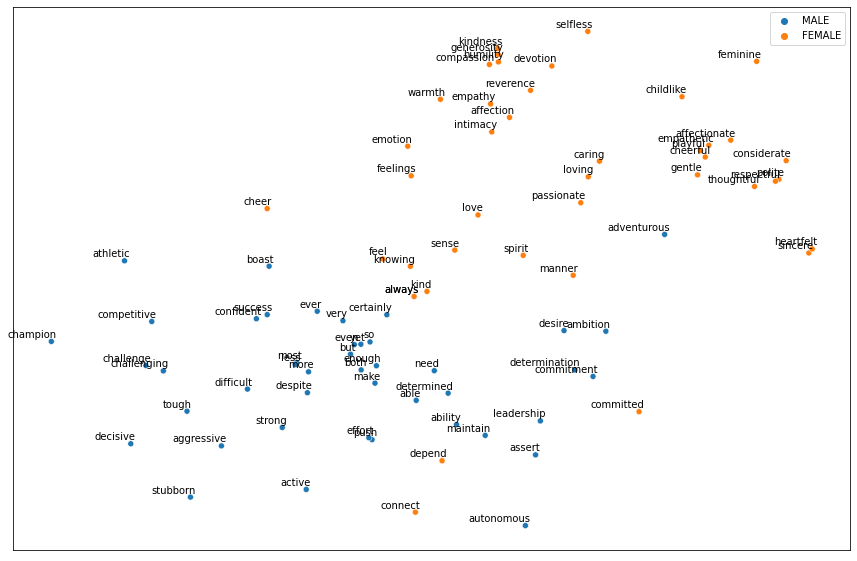

In [15]:
## word embedding
tot_words = [word for v in dic_clusters.values() for word in v]
X = nlp[tot_words]
        
## pca
pca = manifold.TSNE(perplexity=40, n_components=2, init='pca')
X = pca.fit_transform(X)

## create dtf
dtf_GloVe = pd.DataFrame()
for k,v in dic_clusters.items():
    size = len(dtf_GloVe) + len(v)
    dtf_group = pd.DataFrame(X[len(dtf_GloVe):size], columns=["x","y"], index=v)
    dtf_group["cluster"] = k
    dtf_GloVe = dtf_GloVe.append(dtf_group)
        
## plot
%matplotlib inline
fig, ax = plt.subplots(figsize=(15,10))
sns.scatterplot(data=dtf_GloVe, x="x", y="y", hue="cluster", ax=ax)
#ax.legend().texts[0].set_text(None)
ax.legend()
ax.set(xlabel=None, ylabel=None, xticks=[], xticklabels=[], yticks=[], yticklabels=[])
for i in range(len(dtf_GloVe)):
    ax.annotate(dtf_GloVe.index[i], xy=(dtf_GloVe["x"].iloc[i], dtf_GloVe["y"].iloc[i]), xytext=(5,2), textcoords='offset points', ha='right', va='bottom')

# BERT

In [16]:
tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
nlp = BertModel.from_pretrained("bert-base-uncased")

KeyboardInterrupt: 

In [ ]:
## function to apply
def utils_bert_embedding(txt, tokenizer, nlp):
    # tokenize sentence to tokens (integers)
    x = tokenizer.encode(txt, max_length=512)
    # convert to array of shape (1, num_words+2) - EOS and CLS added
    idx = torch.tensor(x)[None,:]
    # generate embeddings for each token - output is a tuple
    emb = nlp(idx)
    # select first member of the tuple, remove first dimension which is 1 to get (num_words,embedding size 712)
    # exclude CLS and EOS tokens
    X = torch.tensor(emb[0][0][1:-1])
    return X

In [ ]:
## create list of news vector
lst_mean_vecs = [utils_bert_embedding(txt, tokenizer, nlp).mean(0) for txt in tqdm(df["text_clean"][:10])]

  0%|          | 0/10 [00:00<?, ?it/s]

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
C:\Users\Sam's PC\AppData\Local\Temp\ipykernel_27860\1828777685.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(emb[0][0][1:-1])


In [ ]:
## create the feature matrix (n news x 768)
print(type(lst_mean_vecs))
X = torch.stack(lst_mean_vecs)
print(type(X))
X.shape

<class 'list'>
<class 'torch.Tensor'>


torch.Size([10, 768])

In [ ]:
# Create y as {label:mean_vector}
test = [utils_bert_embedding(v, tokenizer, nlp).mean(0) for v in tqdm(dic_clusters["MALE"])]
y = torch.stack(test)
#dic_y = {k:utils_bert_embedding(v, tokenizer, nlp).mean(0) for k,v in tqdm(dic_clusters.items())}

  0%|          | 0/45 [00:00<?, ?it/s]

C:\Users\Sam's PC\AppData\Local\Temp\ipykernel_27860\1828777685.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(emb[0][0][1:-1])


In [ ]:
X

tensor([[-0.3498, -0.0357,  0.4508,  ..., -0.0720, -0.1315, -0.0227],
        [-0.3567,  0.1390,  0.3310,  ..., -0.2749, -0.0328, -0.3153],
        [-0.0714,  0.0555,  0.5164,  ..., -0.1742, -0.1620, -0.0079],
        ...,
        [-0.4190, -0.0112,  0.3714,  ..., -0.2935, -0.1867, -0.2660],
        [-0.1295, -0.0196,  0.4614,  ..., -0.1498, -0.3309,  0.0643],
        [-0.2823, -0.0098,  0.5071,  ..., -0.2583, -0.0297, -0.0561]])

In [ ]:
y

tensor([[ 3.0812e-02, -3.9627e-01,  4.9592e-01,  ...,  6.1124e-02,
          3.8321e-01, -2.1730e-01],
        [ 1.1616e-01, -2.8576e-01, -2.1634e-01,  ..., -4.4898e-02,
          1.1010e-01,  6.9657e-02],
        [-1.3328e+00, -8.2812e-01,  1.5087e-01,  ..., -3.1346e-02,
          7.1686e-01, -3.4773e-01],
        ...,
        [ 1.1242e-02, -1.8388e-01, -3.3272e-01,  ...,  2.2211e-01,
          3.9449e-01,  1.0580e-01],
        [ 1.0483e-01, -3.8735e-01, -1.0470e-01,  ...,  1.6531e-01,
          1.3210e-01, -1.0763e-01],
        [ 1.0311e-01, -1.1287e-01,  2.5985e-04,  ..., -1.3070e-01,
         -2.7054e-01,  5.6284e-01]])

In [ ]:
dic_y
print(dic_y.keys())

NameError: name 'dic_y' is not defined

In [ ]:
#--- Model Algorithm ---#
# compute cosine similarities
#for z in dic_y.values():

x = torch.Tensor.cpu(X).detach().numpy()
y = torch.Tensor.cpu(X).detach().numpy()
#y.reshape(1,-1)
print(type(x))
print(type(y))
print(x.shape)
print(y.shape)
    
similarities = np.array([pairwise_distances(x, y, metric = 'euclidean')]).T
print(type(similarities))
## adjust and rescale
labels = ["MALE", "FEMALE"]
for i in range(len(similarities)):
    ### assign randomly if there is no similarity
    if sum(similarities[i]) == 0:
       similarities[i] = [0]*len(labels)
       similarities[i][np.random.choice(range(len(labels)))] = 1
    ### rescale so they sum = 1
    similarities[i] = similarities[i] / sum(similarities[i])
    print(similarities[i])

## classify the label with highest similarity score
predicted_prob = similarities
#for pred in predicted_prob:
    #print(np.argmax(pred))

predicted = [labels[np.argmax(pred)] for pred in predicted_prob]

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
(10, 768)
(10, 768)
<class 'numpy.ndarray'>
[[4.2386752e-09]
 [1.1561276e-01]
 [1.0263102e-01]
 [1.2361194e-01]
 [7.8045152e-02]
 [1.2371524e-01]
 [1.0044208e-01]
 [1.3571082e-01]
 [1.3231914e-01]
 [8.7911867e-02]]
[[0.13193297]
 [0.        ]
 [0.10480684]
 [0.09727251]
 [0.10792334]
 [0.10554206]
 [0.09145279]
 [0.11839078]
 [0.13424747]
 [0.10843123]]
[[0.11779287]
 [0.10541015]
 [0.        ]
 [0.10772977]
 [0.10429528]
 [0.10903735]
 [0.09834033]
 [0.12715684]
 [0.12493986]
 [0.10529763]]
[[0.1375625 ]
 [0.09485979]
 [0.10445638]
 [0.        ]
 [0.1077022 ]
 [0.1050045 ]
 [0.10942714]
 [0.10462216]
 [0.12857069]
 [0.10779461]]
[[0.09052031]
 [0.10969021]
 [0.10539606]
 [0.11224966]
 [0.        ]
 [0.12169154]
 [0.10221956]
 [0.13136923]
 [0.13986714]
 [0.08699633]]
[[1.35740787e-01]
 [1.01476423e-01]
 [1.04237035e-01]
 [1.03527434e-01]
 [1.15119115e-01]
 [3.28853389e-09]
 [1.06244311e-01]
 [1.17971785e-01]
 [1.03771187e-01]
 [1.1191193

IndexError: list index out of range

In [ ]:
y_test = dtf_GloVe["y"].values
classes = np.unique(y_test)
y_test_array = pd.get_dummies(y_test, drop_first=False).values

## Accuracy, Precision, Recall
accuracy = metrics.accuracy_score(y_test, predicted)
auc = metrics.roc_auc_score(y_test, predicted_prob, 
                            multi_class="ovr")
print("Accuracy:",  round(accuracy,2))
print("Auc:", round(auc,2))
print("Detail:")
print(metrics.classification_report(y_test, predicted))
    
## Plot confusion matrix
cm = metrics.confusion_matrix(y_test, predicted)
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, 
            cbar=False)
ax.set(xlabel="Pred", ylabel="True", xticklabels=classes, 
       yticklabels=classes, title="Confusion matrix")
plt.yticks(rotation=0)
fig, ax = plt.subplots(nrows=1, ncols=2)

## Plot roc
for i in range(len(classes)):
    fpr, tpr, thresholds = metrics.roc_curve(y_test_array[:,i],  
                           predicted_prob[:,i])
    ax[0].plot(fpr, tpr, lw=3, 
              label='{0} (area={1:0.2f})'.format(classes[i], 
                              metrics.auc(fpr, tpr))
               )
ax[0].plot([0,1], [0,1], color='navy', lw=3, linestyle='--')
ax[0].set(xlim=[-0.05,1.0], ylim=[0.0,1.05], 
          xlabel='False Positive Rate', 
          ylabel="True Positive Rate (Recall)", 
          title="Receiver operating characteristic")
ax[0].legend(loc="lower right")
ax[0].grid(True)
    
## Plot precision-recall curve
for i in range(len(classes)):
    precision, recall, thresholds = metrics.precision_recall_curve(
                 y_test_array[:,i], predicted_prob[:,i])
    ax[1].plot(recall, precision, lw=3, 
               label='{0} (area={1:0.2f})'.format(classes[i], 
                                  metrics.auc(recall, precision))
              )
ax[1].set(xlim=[0.0,1.05], ylim=[0.0,1.05], xlabel='Recall', 
          ylabel="Precision", title="Precision-Recall curve")
ax[1].legend(loc="best")
ax[1].grid(True)
plt.show()

TypeError: Expected sequence or array-like, got <class 'int'>